# Librerías

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Conexión al repositorio de datos

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Lectura de archivos tensoriales

In [3]:
#Leemos el archivo tensorial de entrenamiento
dataset_train = np.load('/content/drive/MyDrive/Data/train_rr.npz', allow_pickle=True)

#Extraemos los features de entrenamiento
x_train = dataset_train['arr_0'][()]['features']

#Extraemos los labels de entrenamiento
y_train = dataset_train['arr_0'][()]['labels']

In [4]:
#Leemos el archivo tensorial de validación
dataset_test = np.load('/content/drive/MyDrive/Data/test_rr.npz', allow_pickle=True)

#Extraemos los features de validación
x_test = dataset_test['arr_0'][()]['features']

#Extraemos los labels de validación
y_test = dataset_test['arr_0'][()]['labels']

# Creación de Rolling Windows

In [5]:
#Para aplicar esta técnica, deberemos volver a convertir los tensores en dataframes pandas
dfTrain = pd.DataFrame(x_train.reshape(-1), columns=['Monto'])
dfTrain

,Monto
0,0.014020
1,0.000000
2,0.070426
3,0.095318
4,0.163628
...,...
234,0.863983
235,0.814394
236,0.799167
237,0.802101


In [6]:
#Vamos a agregar manualmente al dataframe una columna con los valores del mes anterior
#La operación "shift" copia el valor de la siguiente fila y lo coloca en la nueva columna "mes_anterior_1"
dfTrain["mes_anterior_1"] = dfTrain["Monto"].shift(1)
dfTrain

,Monto,mes_anterior_1
0,0.014020,NaN
1,0.000000,0.014020
2,0.070426,0.000000
3,0.095318,0.070426
4,0.163628,0.095318
...,...,...
234,0.863983,0.865311
235,0.814394,0.863983
236,0.799167,0.814394
237,0.802101,0.799167


In [7]:
#Ahora vamos a agregar manualmente al dataframe una columna con los valores del segundo mes anterior
#Esta vez "shift" saltará dos posiciones para extraer el valor de la nueva columna
dfTrain["mes_anterior_2"] = dfTrain["Monto"].shift(2)
dfTrain

,Monto,mes_anterior_1,mes_anterior_2
0,0.014020,NaN,NaN
1,0.000000,0.014020,NaN
2,0.070426,0.000000,0.014020
3,0.095318,0.070426,0.000000
4,0.163628,0.095318,0.070426
...,...,...,...
234,0.863983,0.865311,0.847598
235,0.814394,0.863983,0.865311
236,0.799167,0.814394,0.863983
237,0.802101,0.799167,0.814394


In [8]:
#Extraemos el tercer mes anterior
#Notemos que de esta manera cada registro define 4 features, el monto de ventas del mes actual, y el de los 3 últimos meses
#De esa manera la red tendrá más features qué comparar para poder encontrar más patrones
dfTrain["mes_anterior_3"] = dfTrain["Monto"].shift(3)
dfTrain

,Monto,mes_anterior_1,mes_anterior_2,mes_anterior_3
0,0.014020,NaN,NaN,NaN
1,0.000000,0.014020,NaN,NaN
2,0.070426,0.000000,0.014020,NaN
3,0.095318,0.070426,0.000000,0.014020
4,0.163628,0.095318,0.070426,0.000000
...,...,...,...,...
234,0.863983,0.865311,0.847598,0.784536
235,0.814394,0.863983,0.865311,0.847598
236,0.799167,0.814394,0.863983,0.865311
237,0.802101,0.799167,0.814394,0.863983


In [9]:
#Vamos a volver al dataframe a su forma original
dfTrain = pd.DataFrame(x_train.reshape(-1), columns=['Monto'])
dfTrain

,Monto
0,0.014020
1,0.000000
2,0.070426
3,0.095318
4,0.163628
...,...
234,0.863983
235,0.814394
236,0.799167
237,0.802101


In [10]:
#Y vamos a agregarle la información de los últimos 12 meses
#Esta vez lo haremos de manera iterativa en lugar de manual
for salto in range(1, 12):
  dfTrain['mes_anterior_{}'.format(salto)] = dfTrain['Monto'].shift(salto)

In [11]:
#Al consultar el dataframe, veremos los nuevos features
dfTrain

,Monto,mes_anterior_1,mes_anterior_2,mes_anterior_3,mes_anterior_4,mes_anterior_5,mes_anterior_6,mes_anterior_7,mes_anterior_8,mes_anterior_9,mes_anterior_10,mes_anterior_11
0,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
234,0.863983,0.865311,0.847598,0.784536,0.736050,0.531665,0.597349,0.929722,0.716290,0.773687,0.754447,0.770968
235,0.814394,0.863983,0.865311,0.847598,0.784536,0.736050,0.531665,0.597349,0.929722,0.716290,0.773687,0.754447
236,0.799167,0.814394,0.863983,0.865311,0.847598,0.784536,0.736050,0.531665,0.597349,0.929722,0.716290,0.773687
237,0.802101,0.799167,0.814394,0.863983,0.865311,0.847598,0.784536,0.736050,0.531665,0.597349,0.929722,0.716290


In [12]:
#Como las redes no pueden procesar valores nulos deberemos eliminar los registros que no tengan información
dfTrain = dfTrain.dropna()
dfTrain

,Monto,mes_anterior_1,mes_anterior_2,mes_anterior_3,mes_anterior_4,mes_anterior_5,mes_anterior_6,mes_anterior_7,mes_anterior_8,mes_anterior_9,mes_anterior_10,mes_anterior_11
11,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020
12,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000
13,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426
14,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318
15,0.109831,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628
...,...,...,...,...,...,...,...,...,...,...,...,...
234,0.863983,0.865311,0.847598,0.784536,0.736050,0.531665,0.597349,0.929722,0.716290,0.773687,0.754447,0.770968
235,0.814394,0.863983,0.865311,0.847598,0.784536,0.736050,0.531665,0.597349,0.929722,0.716290,0.773687,0.754447
236,0.799167,0.814394,0.863983,0.865311,0.847598,0.784536,0.736050,0.531665,0.597349,0.929722,0.716290,0.773687
237,0.802101,0.799167,0.814394,0.863983,0.865311,0.847598,0.784536,0.736050,0.531665,0.597349,0.929722,0.716290


In [13]:
#Finalmente obtenemos los valores en un array tensorial
#Para los features usaremos todos los valores previos al mes
x_train_tensor = dfTrain.loc[:, dfTrain.columns != 'Monto'].values
x_train_tensor.shape

(228, 11)

In [14]:
#En este caso los "y" son la columna "Monto"
y_train_tensor = dfTrain['Monto'].values
y_train_tensor.shape

(228,)

In [15]:
#Hacemos lo mismo con los datos de validación
#Vamos a volver al dataframe a su forma original
dfTest = pd.DataFrame(x_test.reshape(-1), columns=['Monto'])
dfTest

,Monto
0,0.614232
1,0.569266
2,0.772596
3,0.835057
4,0.899933
...,...
67,1.098520
68,1.076814
69,1.052339
70,1.101218


In [16]:
#Vamos a agregarle la información de los últimos 12 meses
for salto in range(1, 12):
  dfTest['mes_anterior_{}'.format(salto)] = dfTest['Monto'].shift(salto)

In [17]:
#Vemos los valores
dfTest

,Monto,mes_anterior_1,mes_anterior_2,mes_anterior_3,mes_anterior_4,mes_anterior_5,mes_anterior_6,mes_anterior_7,mes_anterior_8,mes_anterior_9,mes_anterior_10,mes_anterior_11
0,0.614232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.569266,0.614232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.772596,0.569266,0.614232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.835057,0.772596,0.569266,0.614232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.899933,0.835057,0.772596,0.569266,0.614232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
67,1.098520,1.102388,1.137163,1.135161,1.055935,0.943724,0.758063,0.782767,1.159706,1.017693,1.043874,1.027479
68,1.076814,1.098520,1.102388,1.137163,1.135161,1.055935,0.943724,0.758063,0.782767,1.159706,1.017693,1.043874
69,1.052339,1.076814,1.098520,1.102388,1.137163,1.135161,1.055935,0.943724,0.758063,0.782767,1.159706,1.017693
70,1.101218,1.052339,1.076814,1.098520,1.102388,1.137163,1.135161,1.055935,0.943724,0.758063,0.782767,1.159706


In [18]:
#Como las redes no pueden procesar valores nulos deberemos eliminar los registros que no tengan información
dfTest = dfTest.dropna()
dfTest

,Monto,mes_anterior_1,mes_anterior_2,mes_anterior_3,mes_anterior_4,mes_anterior_5,mes_anterior_6,mes_anterior_7,mes_anterior_8,mes_anterior_9,mes_anterior_10,mes_anterior_11
11,1.062650,0.871806,0.840481,0.862208,0.883631,0.893021,0.925520,0.899933,0.835057,0.772596,0.569266,0.614232
12,0.651988,1.062650,0.871806,0.840481,0.862208,0.883631,0.893021,0.925520,0.899933,0.835057,0.772596,0.569266
13,0.643124,0.651988,1.062650,0.871806,0.840481,0.862208,0.883631,0.893021,0.925520,0.899933,0.835057,0.772596
14,0.831765,0.643124,0.651988,1.062650,0.871806,0.840481,0.862208,0.883631,0.893021,0.925520,0.899933,0.835057
15,0.826669,0.831765,0.643124,0.651988,1.062650,0.871806,0.840481,0.862208,0.883631,0.893021,0.925520,0.899933
...,...,...,...,...,...,...,...,...,...,...,...,...
67,1.098520,1.102388,1.137163,1.135161,1.055935,0.943724,0.758063,0.782767,1.159706,1.017693,1.043874,1.027479
68,1.076814,1.098520,1.102388,1.137163,1.135161,1.055935,0.943724,0.758063,0.782767,1.159706,1.017693,1.043874
69,1.052339,1.076814,1.098520,1.102388,1.137163,1.135161,1.055935,0.943724,0.758063,0.782767,1.159706,1.017693
70,1.101218,1.052339,1.076814,1.098520,1.102388,1.137163,1.135161,1.055935,0.943724,0.758063,0.782767,1.159706


In [19]:
#Finalmente obtenemos los valores en un array tensorial
x_test_tensor = dfTest.loc[:, dfTest.columns != 'Monto'].values
x_test_tensor.shape

(61, 11)

In [20]:
#En este caso los "y" son la columna "Monto"
y_test_tensor = dfTest['Monto'].values
y_test_tensor.shape

(61,)

In [21]:
#Estas son las variables que procesaremos
x_train_tensor.shape, y_train_tensor.shape, x_test_tensor.shape, y_test_tensor.shape

((228, 11), (228,), (61, 11), (61,))

# Implementación con una red neuronal clásica

In [22]:
#Vamos a resolver esto como si se tratase de una red neuronal en donde el orden no importa

In [23]:
#Importamos las librerías para implementar la red 
from keras.models import Sequential
from keras.layers import Dense

In [25]:
#Instanciamos un modelo
model = Sequential()

In [26]:
#Agregamos una capa de 6 neuronas, como tenemos 11 features, también agregamos 11 inputs
model.add(Dense(6, input_dim=11, activation='relu'))

In [27]:
#Agregamos la capa de salida de una neurona, ya que devuelve un valor
model.add(Dense(1))

In [28]:
#Compilamos
model.compile(loss='mean_squared_error', optimizer='adam')

In [29]:
#Entrenamos
model.fit(
  x_train_tensor, 
  y_train_tensor, 
  epochs=10,
  batch_size=2, 
  verbose=1
)

Epoch 1/10
114/114 [==============================] - 1s 1ms/step - loss: 0.2436
Epoch 2/10
114/114 [==============================] - 0s 1ms/step - loss: 0.0210
Epoch 3/10
114/114 [==============================] - 0s 1ms/step - loss: 0.0150
Epoch 4/10
114/114 [==============================] - 0s 1ms/step - loss: 0.0137
Epoch 5/10
114/114 [==============================] - 0s 1ms/step - loss: 0.0125
Epoch 6/10
114/114 [==============================] - 0s 1ms/step - loss: 0.0116
Epoch 7/10
114/114 [==============================] - 0s 1ms/step - loss: 0.0113
Epoch 8/10
114/114 [==============================] - 0s 1ms/step - loss: 0.0110
Epoch 9/10
114/114 [==============================] - 0s 1ms/step - loss: 0.0106
Epoch 10/10
114/114 [==============================] - 0s 1ms/step - loss: 0.0106


In [30]:
#Usamos el modelo para predecir los datos de testeo
y_prediccion = model.predict(x_test_tensor)

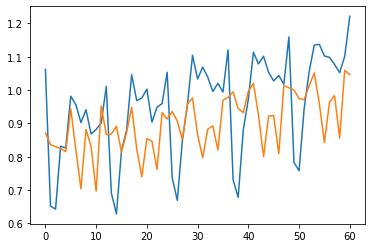

In [31]:
#Graficamos los "y" reales y los "y" predichos
plt.plot(y_test_tensor)
plt.plot(y_prediccion)

# Tensor de orden 3 estándar para las redes recurrentes

In [32]:
#Estas son las variables que procesaremos
x_train_tensor.shape, y_train_tensor.shape, x_test_tensor.shape, y_test_tensor.shape

((228, 11), (228,), (61, 11), (61,))

In [33]:
#A los features deberemos darle la forma tensorial de orden 3 que necesitan las redes recurrentes
#Primero lo haremos con los features de entrenamiento
x_train_tensor_rr = x_train_tensor[:, None, :]
x_train_tensor_rr.shape

(228, 1, 11)

In [34]:
#Ahora los features de validación
x_test_tensor_rr = x_test_tensor[:, None, :]
x_test_tensor_rr.shape

(61, 1, 11)

# Rolling Windows

In [35]:
#Importamos las librerías para implementar la red 
from keras.models import Sequential
from keras.layers import Dense

In [36]:
#Esta vez resolveremos el problema con una red recurrente
#Importamos el objeto que nos permite definir una capa recurrente
from keras.layers import LSTM

In [68]:
#Instanciamos un modelo
model = Sequential()

In [69]:
#Agregamos una capa de recurrente de 6 neuronas, en input_shape deberemos colocar de cuánto en cuánto se procesan los datos (1) y luego cuántos features tenemos (11)
#Con "return_sequences" devolvemos lo procesado para la siguiente capa
model.add(LSTM(4, input_shape=(1, 11), return_sequences=True))

In [70]:
#Agregamos otra capa
model.add(LSTM(8, return_sequences=True))

In [71]:
#Agregamos la última capa, como es la última LSTM no necesita el "return_sequences"
model.add(LSTM(16))

In [72]:
#Agregamos la neurona de salida
model.add(Dense(1))

# Compilación

In [73]:
#Compilamos
model.compile(loss='mean_squared_error', optimizer='adam')

# Entrenamiento

In [74]:
#Entrenamos
model.fit(
  x_train_tensor_rr, 
  y_train_tensor, 
  epochs=100,
  batch_size=2, 
  verbose=1
)

Epoch 1/100
114/114 [==============================] - 4s 4ms/step - loss: 0.1315
Epoch 2/100
114/114 [==============================] - 0s 4ms/step - loss: 0.0299
Epoch 3/100
114/114 [==============================] - 0s 4ms/step - loss: 0.0158
Epoch 4/100
114/114 [==============================] - 0s 4ms/step - loss: 0.0109
Epoch 5/100
114/114 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 6/100
114/114 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 7/100
114/114 [==============================] - 0s 4ms/step - loss: 0.0086
Epoch 8/100
114/114 [==============================] - 0s 4ms/step - loss: 0.0087
Epoch 9/100
114/114 [==============================] - 0s 4ms/step - loss: 0.0085
Epoch 10/100
114/114 [==============================] - 0s 4ms/step - loss: 0.0092
Epoch 11/100
114/114 [==============================] - 0s 4ms/step - loss: 0.0085
Epoch 12/100
114/114 [==============================] - 0s 4ms/step - loss: 0.0085
Epoch 13/100


# Uso del modelo

In [75]:
#Usamos el modelo para predecir los datos de testeo
y_prediccion = model.predict(x_test_tensor_rr)

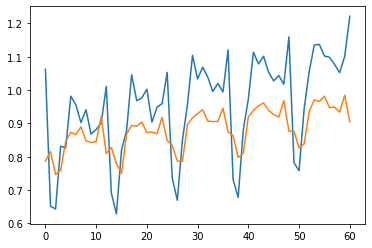

In [76]:
#Graficamos los "y" reales y los "y" predichos
plt.plot(y_test_tensor)
plt.plot(y_prediccion)

In [77]:
#Para usar el modelo, deberemos pasarle las ventas de los últimos 11 meses
x = np.array([1.101218, 1.052339, 1.076814, 1.098520, 1.102388, 1.137163, 1.135161, 1.055935, 0.943724, 0.758063, 0.782767])

In [78]:
#No tiene la forma tensorial estándar, se la deberemos dar
x.shape

(11,)

In [80]:
#Tensorizamos, arreglo de orden 3
x_tensor = x[None, None, :]
x_tensor.shape

(1, 1, 11)

In [81]:
#Usamos el modelo para predecir
#Nos dará la predicción escalada, deberemos convertirla a su valor original
mes_siguiente_1 = model.predict(x_tensor)
mes_siguiente_1

array([[0.90480995]], dtype=float32)

In [50]:
#Cargaremos un dataset original
dfData = pd.read_csv('/content/drive/MyDrive/Data/ventas.csv')
dfData

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083
...,...,...,...
308,Sep-2016,45528702,44534797
309,Oct-2016,44770113,45061618
310,Nov-2016,46285062,45141762
311,Dec-2016,50016137,44943929


In [51]:
#Importamos la librería para reescalar
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [52]:
#Instanciamos el escalador con los datos
x_scaler = sc.fit_transform(dfData[['Unadjusted']])

In [53]:
#Obtenemos el valor no escalado
mes_siguiente_1_no_escalado = sc.inverse_transform(mes_siguiente_1)
mes_siguiente_1_no_escalado

array([[46433456.]], dtype=float32)

In [54]:
#Si queremos obtener la predicción dos meses a futuro deberemos enviarle los 11 meses anteriores incluyendo la predicción que acabamos de realizar
x2 = np.array([0.92748433, 1.101218, 1.052339, 1.076814, 1.098520, 1.102388, 1.137163, 1.135161, 1.055935, 0.943724, 0.758063])

#Tensorizamos
x2_tensor = x2[None, None, :]

#Predecimos
mes_siguiente_2 = model.predict(x2_tensor)

#Obtenemos el valor no escalado
mes_siguiente_2_no_escalado = sc.inverse_transform(mes_siguiente_2)
mes_siguiente_2_no_escalado

array([[42307704.]], dtype=float32)

In [55]:
#Para extraer sólo el número debemos hacerlo así
mes_siguiente_2_no_escalado[0][0]

42307704.0

In [ ]:
#Para evitar hacer todo esto de manera manual vamos a crear una función utilitaria

# Función utilitaria para el uso del modelo

In [56]:
#Funcion utilitaria
def predecir_red_recurrente(cantidad_predicciones, data_sin_escalar, features):
  #Aqui colocaremos las predicciones
  predicciones = np.zeros(cantidad_predicciones)

  #Copiamos los datos a procesar
  input = features

  #Obtenemos el escalador
  sc = MinMaxScaler()
  x_scaler = sc.fit_transform(data_sin_escalar)

  #Iteramos la cantidad de predicciones solicitadas
  for i in range(0, cantidad_predicciones):
    #Convertimos en un array numpy
    features_numpy = np.array(input)

    #Tensorizamos
    input_tensor = features_numpy[None, None, :]

    #Predecimos
    prediccion = model.predict(input_tensor)

    #Des-escalamos
    prediccion_no_escalada = sc.inverse_transform(prediccion)[0][0]

    #Colocamos la prediccion en el array
    predicciones[i] = prediccion_no_escalada

    #Modificamos vector de features agregando la predicción y eliminando el último elemento
    input = [prediccion_no_escalada] + input[:-1]
  
  #Devolvemos las predicciones
  return predicciones

In [57]:
#Usamos la función para obtener las predicciones de los próximos 5 meses
predicciones = predecir_red_recurrente(5, dfData[['Unadjusted']], [1.101218, 1.052339, 1.076814, 1.098520, 1.102388, 1.137163, 1.135161, 1.055935, 0.943724, 0.758063, 0.782767])
predicciones

array([46433456., 13967451., 16969490., 35848768., 43304580.])